# Differential Data Augmentation Techniques for Medical Imaging Classification
#### Baseline Model Notebook

## Import Packages

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader, Dataset
from torch.utils.data import random_split, TensorDataset, DataLoader
%matplotlib inline
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image

# Imports for plotting
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve

# Imports for Loading Data
import tensorflow as tf
import cv2

# Imports for Model Validations
from sklearn.metrics import accuracy_score, precision_score, roc_curve
from sklearn.metrics import recall_score, f1_score, confusion_matrix, roc_auc_score

# Data Wranging

In [2]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

In [3]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))
    
    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }   

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])        
        image=image.numpy()
        image=cv2.resize(image,(224,224))
        image=cv2.merge([image,image,image])        
        #plt.imshow(image)
        images.append(image)
        labels.append(image_features['label_normal'].numpy())

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
filenames=['/content/drive/MyDrive/Colab Notebooks/ECE661_FinalProject/Data/training10_0.tfrecords'
         # ,'/content/drive/MyDrive/Colab Notebooks/ECE661_FinalProject/Data/training10_1.tfrecords'
         # ,'/content/drive/MyDrive/Colab Notebooks/ECE661_FinalProject/Data/training10_2.tfrecords'
         # ,'/content/drive/MyDrive/Colab Notebooks/ECE661_FinalProject/Data/training10_3.tfrecords'
         # ,'/content/drive/MyDrive/Colab Notebooks/ECE661_FinalProject/Data/training10_4.tfrecords'
         ]

for file in filenames:
    read_data(file)
    
print(len(images))
print(len(labels))

Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
11177
11177


## Create Train-Val-Test Split 

### Get 1000 True cases and 1000 False cases

In [6]:
Y = pd.DataFrame({'Y':labels})
true_cases = list(Y[Y['Y'] == 1].copy().index)[0:1000]
false_cases = list(Y[Y['Y'] == 0].copy().index)[0:1000]
ind = true_cases + false_cases
print(len(ind))

2000


In [7]:
y = np.array([labels[i] for i in ind])
X = np.array([images[i] for i in ind])

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y ,random_state=2021,shuffle=True)

In [9]:
print('80-20 Split')
print('X-Train Shape: ', x_train.shape)
print('X-Test Shape: ', x_test.shape)

80-20 Split
X-Train Shape:  (1600, 224, 224, 3)
X-Test Shape:  (400, 224, 224, 3)


### Create Custom Tensor Dataset (To Allow for Transform data augmentation techniques)

In [10]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


### Calculate Mean and Std For Transform Method

In [11]:
# nimages = 0
# mean = 0.0
# var = 0.0

# for i_batch, batch_target in enumerate(train_dataloader):
#     batch = batch_target[0]
#     # Rearrange batch to be the shape of [B, C, W * H]
#     batch = batch.view(batch.size(0), batch.size(1), -1)
#     # Update total number of images
#     nimages += batch.size(0)
#     # Compute mean and std here
#     mean += batch.mean(2).sum(0) 
#     var += batch.var(2).sum(0)

# mean /= nimages
# var /= nimages
# std = torch.sqrt(var)

# print(mean)
# print(std)

Normalization Metrics from running the above code snippet: 

Mean: tensor([105.7823, 105.7823, 105.7823])


Std: tensor([26.6096, 26.6096, 26.6096])

In [12]:
# Define preprocessing
trsfm = transforms.Compose([
                            
        #transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize((105.7823, 105.7823, 105.7823), (26.6096, 26.6096, 26.6096))
        ])

# Train
tensor_trainX = torch.Tensor(x_train) # transform to torch tensor
tensor_trainY = torch.Tensor(y_train)
tensor_trainX = tensor_trainX.permute(0, 3, 1, 2)

# Test
tensor_testX = torch.Tensor(x_test) # transform to torch tensor
tensor_testY = torch.Tensor(y_test)
tensor_testX = tensor_testX.permute(0, 3, 1, 2)

In [13]:
train_tensor = CustomTensorDataset(tensors=(tensor_trainX,tensor_trainY), transform=None) # create your datset
train_dataloader = DataLoader(train_tensor, batch_size=64, shuffle=True) # create your dataloader

test_tensor = CustomTensorDataset(tensors=(tensor_testX,tensor_testY), transform=None) # create your datset
test_dataloader = DataLoader(test_tensor, batch_size=64, shuffle=False) # create your dataloader

## Create VGG16 model

In [14]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 4096)
        self.fc2 = nn.Linear(4096, 1000)
        self.fc3 = nn.Linear(1000, 2)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

## Prepare model for Training

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda

model = VGG16() #to compile the model
model = model.to(device=device) #to send the model for training on either cuda or cpu

## Loss and optimizer
learning_rate = 1e-4 #I picked this because it seems to be the most used by experts
l2_reg = 1e-7

load_model = True
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr= learning_rate, weight_decay=l2_reg) #Adam seems to be the most popular for deep learning

## Training

In [16]:
# some hyperparameters
# total number of training epochs
EPOCHS = 50

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
train_accur = []
test_accur = []

best_predictions = []
best_output_probs = []

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):

    all_predictions = []
    all_outputs = []    
    #######################
    # your code here
    # switch to train mode
    model.train()
    #######################
    
    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        ####################################
        # your code here
        # copy inputs to device
        # Convert to Pytorch (N, C, H, W)
        #inputs = inputs.permute(0, 3, 1, 2)
        images = inputs.to(device)
        # print(batch_idx)
        # print(images.shape)

        targets = targets.to(device=device).long()
        
        # compute the output and loss
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation
        loss.backward()
        
        # apply gradient and update the weights
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        
        # count the number of correctly predicted samples in the current batch
        correct = predicted.eq(targets).sum()
        
        total_examples += targets.shape[0]
        train_loss += loss
        correct_examples += correct.item()
        
        ####################################
    
    avg_loss = train_loss / len(train_dataloader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    train_accur.append(avg_acc)

    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    model.eval()
    
    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_dataloader):
            ####################################
            # your code here
            # copy inputs to device
            # Convert to Pytorch (N, C, H, W)
            #inputs = inputs.permute(0, 3, 1, 2)
            images = inputs.to(device)

            targets = targets.to(device=device).long()
            
            # compute the output and loss
            outputs = model(images)
            all_outputs.append(outputs[:,1].cpu().numpy())


            loss = criterion(outputs, targets)
            
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()
            all_predictions.append(predicted.cpu().numpy())

            total_examples += targets.shape[0]
            val_loss += loss
            correct_examples += correct.item()
            
            ####################################
    
    avg_loss = val_loss / len(test_dataloader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    test_accur.append(avg_acc)

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc

        all_predictions = np.concatenate(all_predictions).ravel()
        best_predictions = all_predictions

        all_outputs = np.concatenate(all_outputs).ravel()
        best_output_probs = all_outputs

        print("Saving ...")
        state = {'state_dict': model.state_dict(),
                 'epoch': i,
                 'lr': learning_rate}
        torch.save(state,'baseline_model.pth')
        
    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 0.6841, Training accuracy: 0.6094
Validation loss: 0.6384, Validation accuracy: 0.6175
Saving ...

Epoch 1:
Training loss: 0.5948, Training accuracy: 0.6794
Validation loss: 0.5845, Validation accuracy: 0.6300
Saving ...

Epoch 2:
Training loss: 0.5349, Training accuracy: 0.7231
Validation loss: 0.5588, Validation accuracy: 0.6775
Saving ...

Epoch 3:
Training loss: 0.5333, Training accuracy: 0.7256
Validation loss: 0.5352, Validation accuracy: 0.6950
Saving ...

Epoch 4:
Training loss: 0.5245, Training accuracy: 0.7306
Validation loss: 0.6109, Validation accuracy: 0.6875

Epoch 5:
Training loss: 0.5690, Training accuracy: 0.7019
Validation loss: 0.5497, Validation accuracy: 0.7525
Saving ...

Epoch 6:
Training loss: 0.5068, Training accuracy: 0.7394
Validation loss: 0.5487, Validation accuracy: 0.7525

Epoch 7:
Training loss: 0.5108, Training accuracy: 0.7425
Validation loss: 0.6322, Validation accuracy: 0.6200

Epoch 8:
Training loss: 0.53

# Model Performance Validation

### Training and Testing Accuracy Over Time

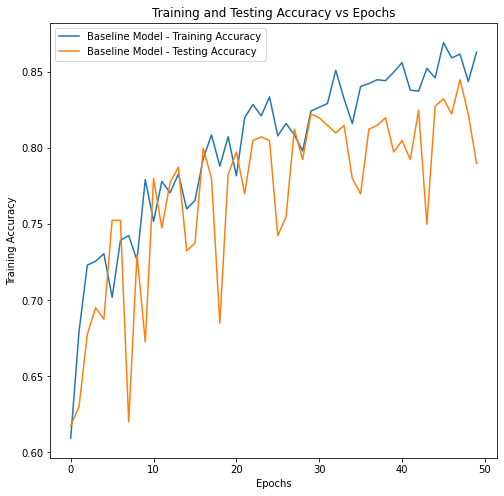

In [17]:
plt.figure(figsize=(8,8))
plt.plot(range(EPOCHS),train_accur, label='Baseline Model - Training Accuracy')
plt.plot(range(EPOCHS),test_accur, label='Baseline Model - Testing Accuracy')

plt.title('Training and Testing Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

### Calculate Accuracy, Precision, Recall, and F1

In [18]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, best_predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, best_predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, best_predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, best_predictions)
print('F1 score: %f' % f1)

Accuracy: 0.845000
Precision: 0.805310
Recall: 0.910000
F1 score: 0.854460


### Calculate Confusion Matrix

In [19]:
unique_label = np.unique([y_test, best_predictions])
cmtx = pd.DataFrame(
    confusion_matrix(y_test, best_predictions, labels=unique_label), 
    index=['true:{:}'.format(x) for x in unique_label], 
    columns=['pred:{:}'.format(x) for x in unique_label]
)

cmtx

,pred:0,pred:1
true:0,156,44
true:1,18,182


### Calculate ROC

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, best_output_probs)
auc = roc_auc_score(y_test, best_output_probs)

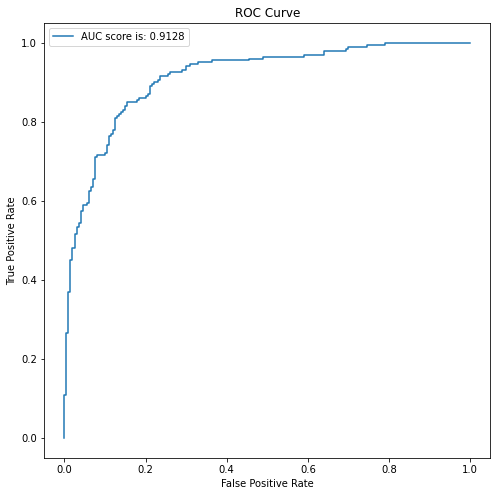

In [21]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='AUC score is: '+str(round(auc, 4)))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [22]:
auc

0.9128499999999999